# Quad modelling notebook

With this notebook, we provide an example of how to model a quadrupoly lensed quasar lens with a host galaxy and a lens galaxy component. The example is highly simplified and as we choose the same input model, a "perfect" reconstructio can be expected. Convergence in the PSO and MCMC chain is not guaranteed and this example provides a small run for illustration purpose.

We recommend to first go through the starting guide notebook, where the building blocks of *lenstronomy* are explained in detail.

In this notebook, we first create a mock image of a quadrupoly lensed quasar and then apply a PSO and an MCMC chain to recover the input lens parameters.

*lenstronomy* comes with a set of neat features that facilitate the modelling of quad lenses. This notebook introduces those features and how to use them.

In [1]:
# some python imports
__author__ = 'sibirrer'
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.SimulationAPI.simulations import Simulation
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import Data
from lenstronomy.Data.psf import PSF
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Workflow.parameters import Param


## creating a mock image of a quad
We follow closely the starting guide in how we create a mock image with noise properties. In this example we use an elliptical power-law convergence profile with external shear as the lens model, two different Sersic profiles as the light components of the deflector and the quasar host galaxy and a HST-like resolution of the image.

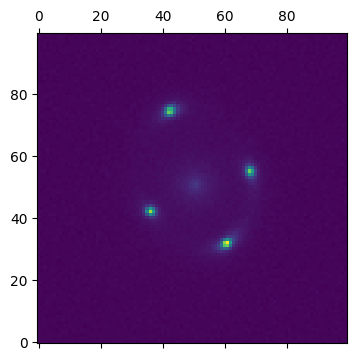

In [2]:
SimAPI = Simulation()

# data specifics
sigma_bkg = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF

# PSF specification

data_class = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
psf_class = SimAPI.psf_configure(psf_type='GAUSSIAN', fwhm=fwhm, kernelsize=31, deltaPix=deltaPix,
                                               truncate=6,
                                               kernel=None)
psf_class = SimAPI.psf_configure(psf_type='PIXEL', fwhm=fwhm, kernelsize=11, deltaPix=deltaPix,
                                                    truncate=6,
                                                    kernel=psf_class.kernel_point_source)


lens_model_list = ['SPEP', 'SHEAR']
kwargs_shear = {'e1': 0.01, 'e2': 0.01}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# list of light profiles (for lens and source)
# 'SERSIC': spherical Sersic profile
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 1., 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
# 'SERSIC_ELLIPSE': elliptical Sersic profile

source_model_list = ['SERSIC_ELLIPSE']
ra_source, dec_source = 0, 0.1
kwargs_sersic_ellipse = {'amp': 10., 'R_sersic': .1, 'n_sersic': 3, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': -0.1, 'e2': 0.01}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*100}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = SimAPI.simulate(imageModel, kwargs_lens, kwargs_source,
                                         kwargs_lens_light, kwargs_ps)

data_class.update_data(image_sim)

plt.matshow(image_sim, origin='lower')
plt.show()

## Setup of the modelling

*lenstronomy* comes with some neat features that facilitate the modeling of quadrupoly lensed quasars. Among them are:

- one can couple different parameters together. E.g. the center of the source surface brightness of the host galaxy to the position of the quasar in the source plane. The keyword 'fix_to_point_source_list' can be set to 'True' for each individual index of the source surface brightness profile.

- The image positions of the quasar can be used as constraints on the lens model. Rather then having all lens model parameters as free parameters and solve for the image positions of the quasar, the image positions are treated as free parameters and part of the lens model parameters will be infered in post-processing by a non-linear solver. This option makes convergence in the lens model much faster. The option is set with the keyword 'solver'. There are two options available:
   - 'PROFILE': This solver inferes the center, ellipticities and Einstein radius of the first lens model by the best solution in mapping the four image positions to the same source plane position. This solver may not always find a precise solution.
   - 'PROFILE_SHEAR': This solver, takes in addition to 'PROFILE' also the shear angle (must be specified as the second lens model) to be solved in the demand of mapping the four point source images to the exact same source plane position.


In [3]:
kwargs_model = {'lens_model_list': lens_model_list,
                               'source_light_model_list': source_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               'additional_images_list': [False],
                               'fixed_magnification_list': [False],
                             }
kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_center_lens_light': False,
                              'joint_center_source_light': False,
                              'num_point_source_list': [4],
                              'fix_to_point_source_list': [True] * num_source_model,
                              'image_plane_source_list': [False] * num_source_model,
                              'solver': True,
                              'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'point_source_likelihood': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001
                             }

kwargs_data = data_class.constructor_kwargs()
kwargs_psf = psf_class.constructor_kwargs()
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]


In [4]:
# initial guess of non-linear parameters, we chose different starting parameters than the truth #
kwargs_lens_init = [{'theta_E': 1.2, 'e1': 0, 'e2': 0, 'gamma': 2., 'center_x': 0., 'center_y': 0},
    {'e1': 0.0, 'e2': 0.}]
kwargs_source_init = [{'R_sersic': 0.03, 'n_sersic': 1., 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0, 'center_y': 0}]
kwargs_ps_init = [{'ra_image': x_image+0.01, 'dec_image': y_image-0.01}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E_sigma': 0.3, 'e1_sigma': 0.2, 'e2_sigma': 0.2, 'gamma_sigma': .2, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1},
    {'e1_sigma': 0.1, 'e2_sigma': 0.1}]
kwargs_source_sigma = [{'R_sersic_sigma': 0.1, 'n_sersic_sigma': .5, 'center_x_sigma': .1, 'center_y_sigma': 0.1, 'e1_sigma': 0.2, 'e2_sigma': 0.2}]
kwargs_lens_light_sigma = [{'R_sersic_sigma': 0.1, 'n_sersic_sigma': 0.2, 'e1_sigma': 0.1, 'e2_sigma': 0.1, 'center_x_sigma': .1, 'center_y_sigma': 0.1}]
kwargs_ps_sigma = [{'pos_sigma': 0.02}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10., 'center_y': -10},
    {'e1': -.2, 'e2': -0.2}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(x_image), 'dec_image': -10 * np.ones_like(y_image)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10., 'center_y': 10},
    {'e1': 0.2, 'e2': 0.2}]
kwargs_upper_source = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(x_image), 'dec_image': 10 * np.ones_like(y_image)}]

lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{}, {}], kwargs_lower_lens, kwargs_upper_lens]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}], kwargs_lower_lens_light, kwargs_upper_lens_light]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': 1., 'n_particles': 200,
         'n_iterations': 200},
        {'fitting_routine': 'MCMC', 'n_burn': 10, 'n_run': 10, 'walkerRatio': 10, 'mpi': False,
         'sigma_scale': .1}]

lens_result, source_result, lens_light_result, ps_result, cosmo_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)

/Library/Python/2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Library/Python/2.7/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
converged after 190 iterations!
best fit found:  -4972.155976431601 [ 1.99253790e+00 -2.27764938e-04  4.48992145e-03  1.05850025e-01
  2.91550246e+00 -9.09060757e-02  1.08850274e-02  1.03594683e+00
  2.08582157e+00  8.17453677e-05  1.24007207e-03  5.04763272e-01
 -4.02584896e-01  8.88143856e-01 -7.18603164e-01 -9.43899871e-01
  1.19342812e+00  2.15334051e-01 -4.21127919e-01]
(-0.9964240433730662, 'reduced X^2 of best position')
(-4972.155976431601, 'logL')
(9980, 'effective number of data points')
([{'theta_E': 1.0097866254097507, 'center_x': 0.0015431239023923394, 'center_y': 0.0003582501717145122, 'e1': 0.0995176889929461, 'gamma': 1.9925378998266567, 'e2': 0.09957717123045419}, {'e1': 0.0030930421569872277, 'e2': 0.0032625698032056776}], 'lens result')
([{'e1': -0.09090607568236926, 'n_sersic': 2.9155024638623632, 'center_x': 0.0011836573132450179, 'center_y': 0.10286732290249022, 'amp': 1, 'R_s

('reduced chi^2 = ', 0.9866581762286399)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:245: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


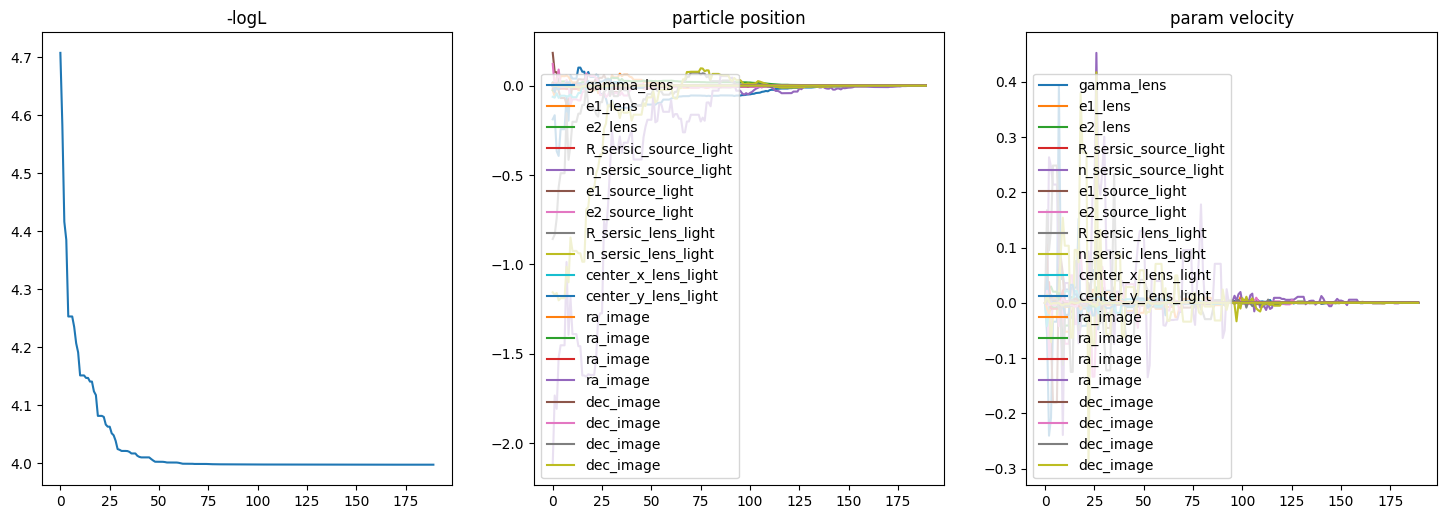

<Figure size 600x400 with 0 Axes>

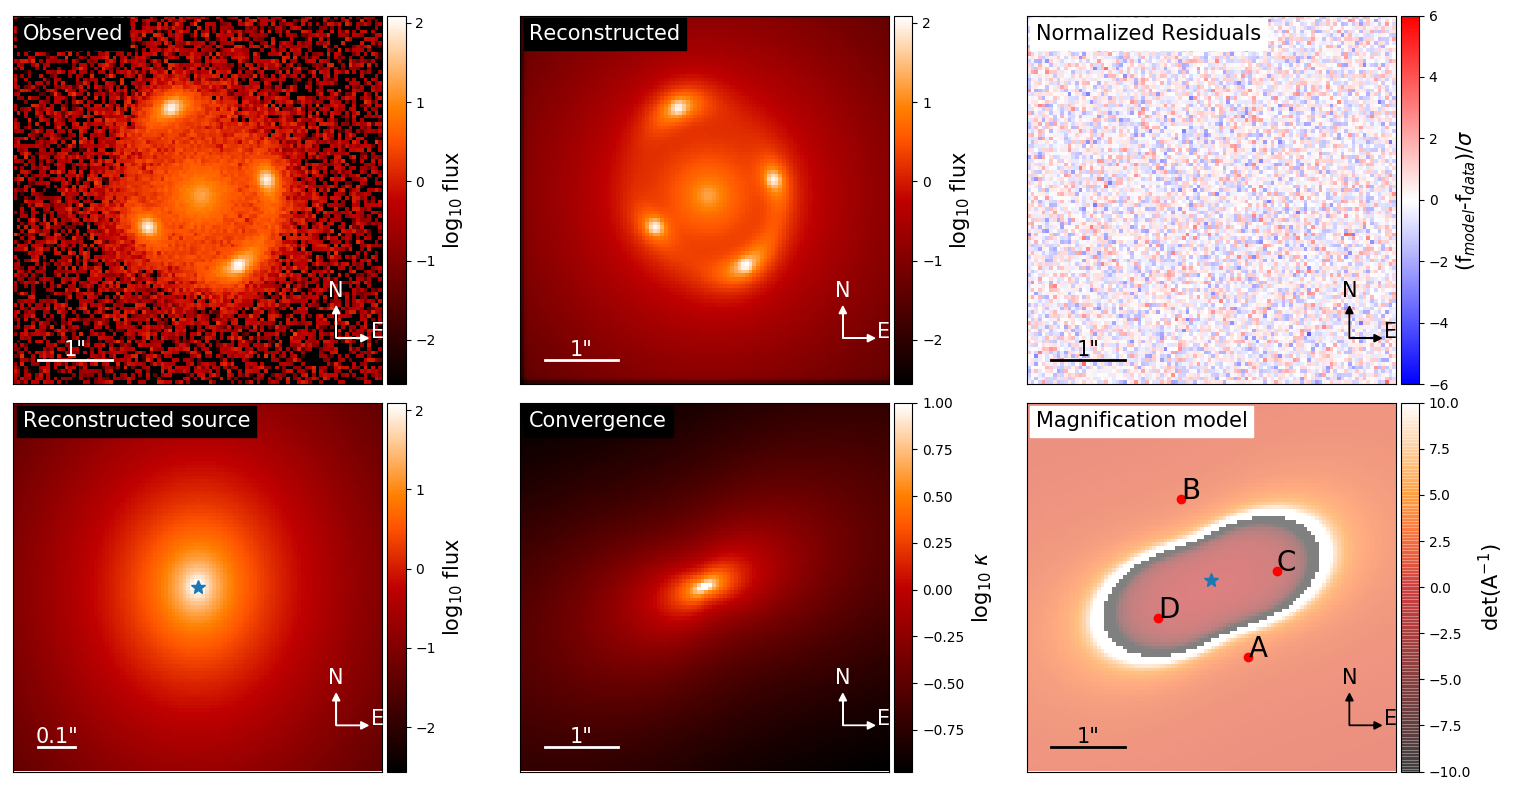

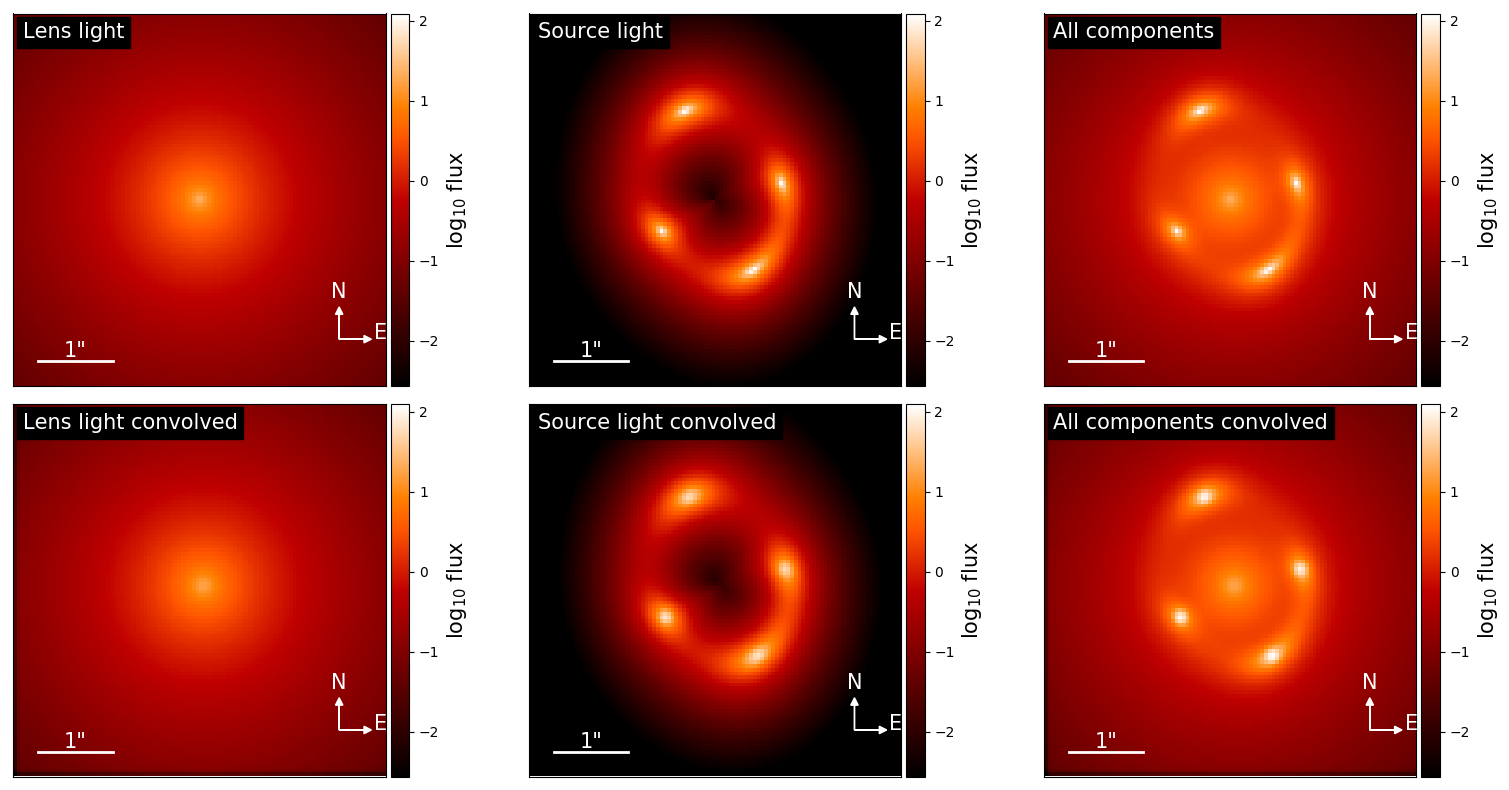

[{'theta_E': 1.0097866254097507, 'center_x': 0.0015431239023923394, 'center_y': 0.0003582501717145122, 'e1': 0.0995176889929461, 'gamma': 1.9925378998266567, 'e2': 0.09957717123045419}, {'e1': 0.0030930421569872277, 'e2': 0.0032625698032056776}] [{'e1': -0.09090607568236926, 'n_sersic': 2.9155024638623632, 'center_x': 0.0011836573132450179, 'center_y': 0.10286732290249022, 'amp': 9.427108972482959, 'R_sersic': 0.105850024709973, 'e2': 0.01088502744658211}] [{'n_sersic': 2.0858215689335498, 'amp': 0.9330433271771346, 'center_x': 8.174536769511146e-05, 'center_y': 0.0012400720653961792, 'R_sersic': 1.0359468342032647}] [{'point_amp': array([307.72985687, 243.37087377, 187.12295632, 158.64219732]), 'ra_image': array([ 0.50476327, -0.4025849 ,  0.88814386, -0.71860316]), 'dec_image': array([-0.94389987,  1.19342812,  0.21533405, -0.42112792])}]


In [5]:
from lenstronomy.Plots.output_plots import LensModelPlot
import lenstronomy.Plots.output_plots as out_plot

lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)

for i in range(len(chain_list)):
        if len(param_list[i]) > 0:
            f, axes = out_plot.plot_chain(chain_list[i], param_list[i])

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0])
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
lensPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print lens_result, source_result, lens_light_result, ps_result

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['gamma_lens', 'e1_lens', 'e2_lens', 'R_sersic_source_light', 'n_sersic_source_light', 'e1_source_light', 'e2_source_light', 'R_sersic_lens_light', 'n_sersic_lens_light', 'center_x_lens_light', 'center_y_lens_light', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  1900


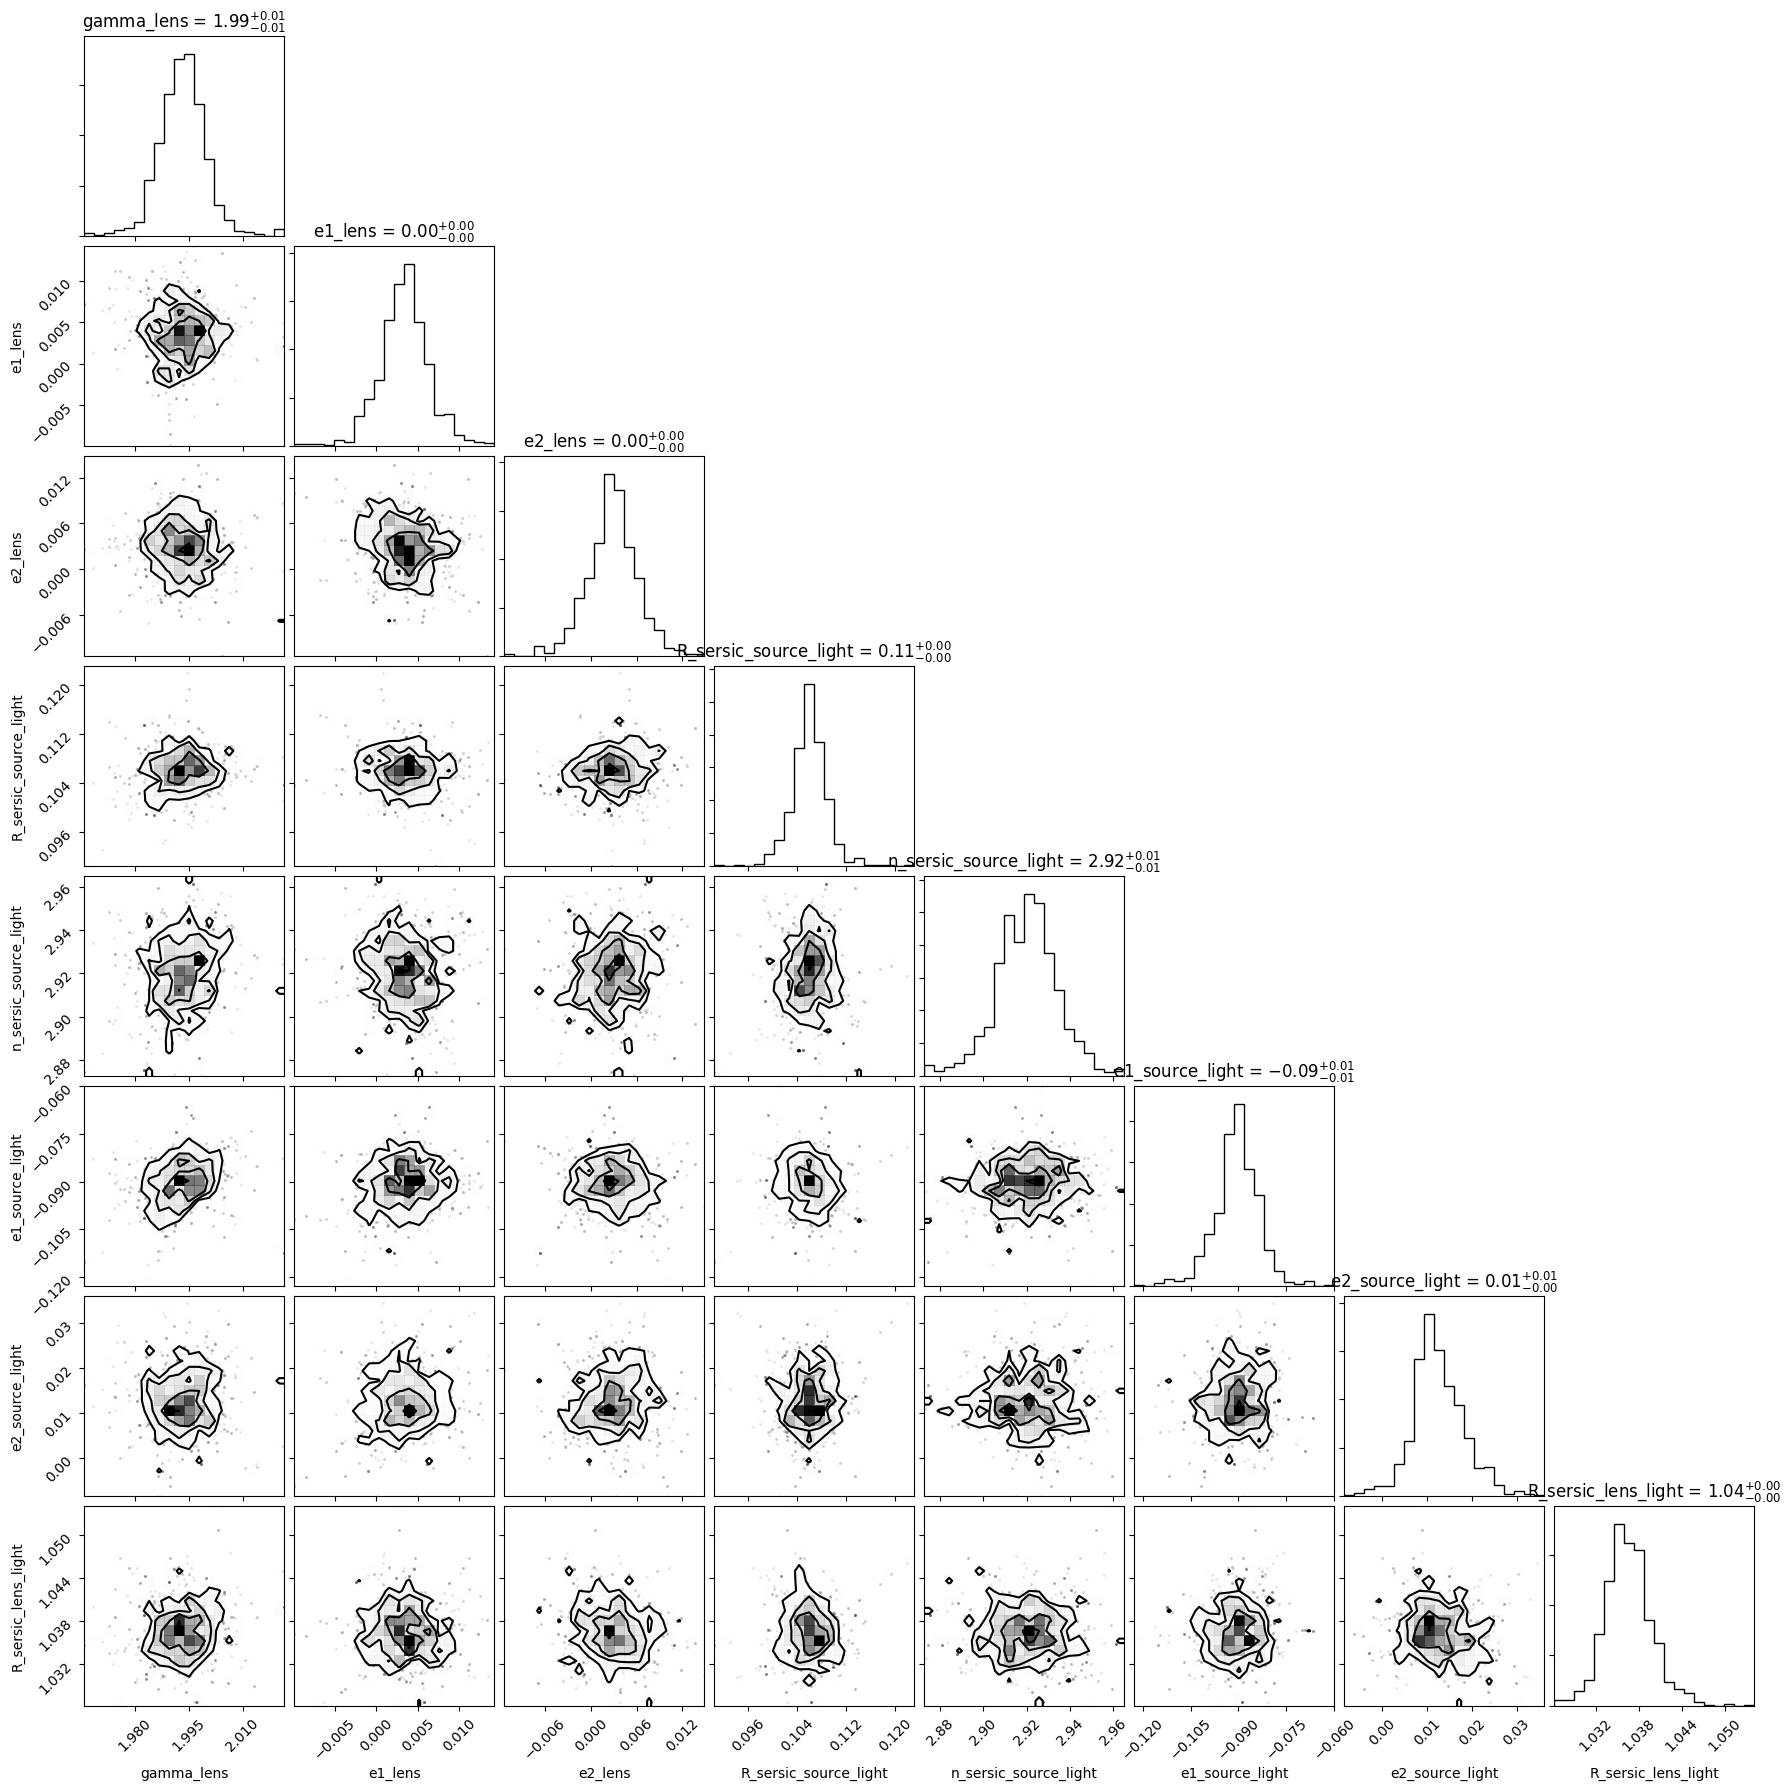

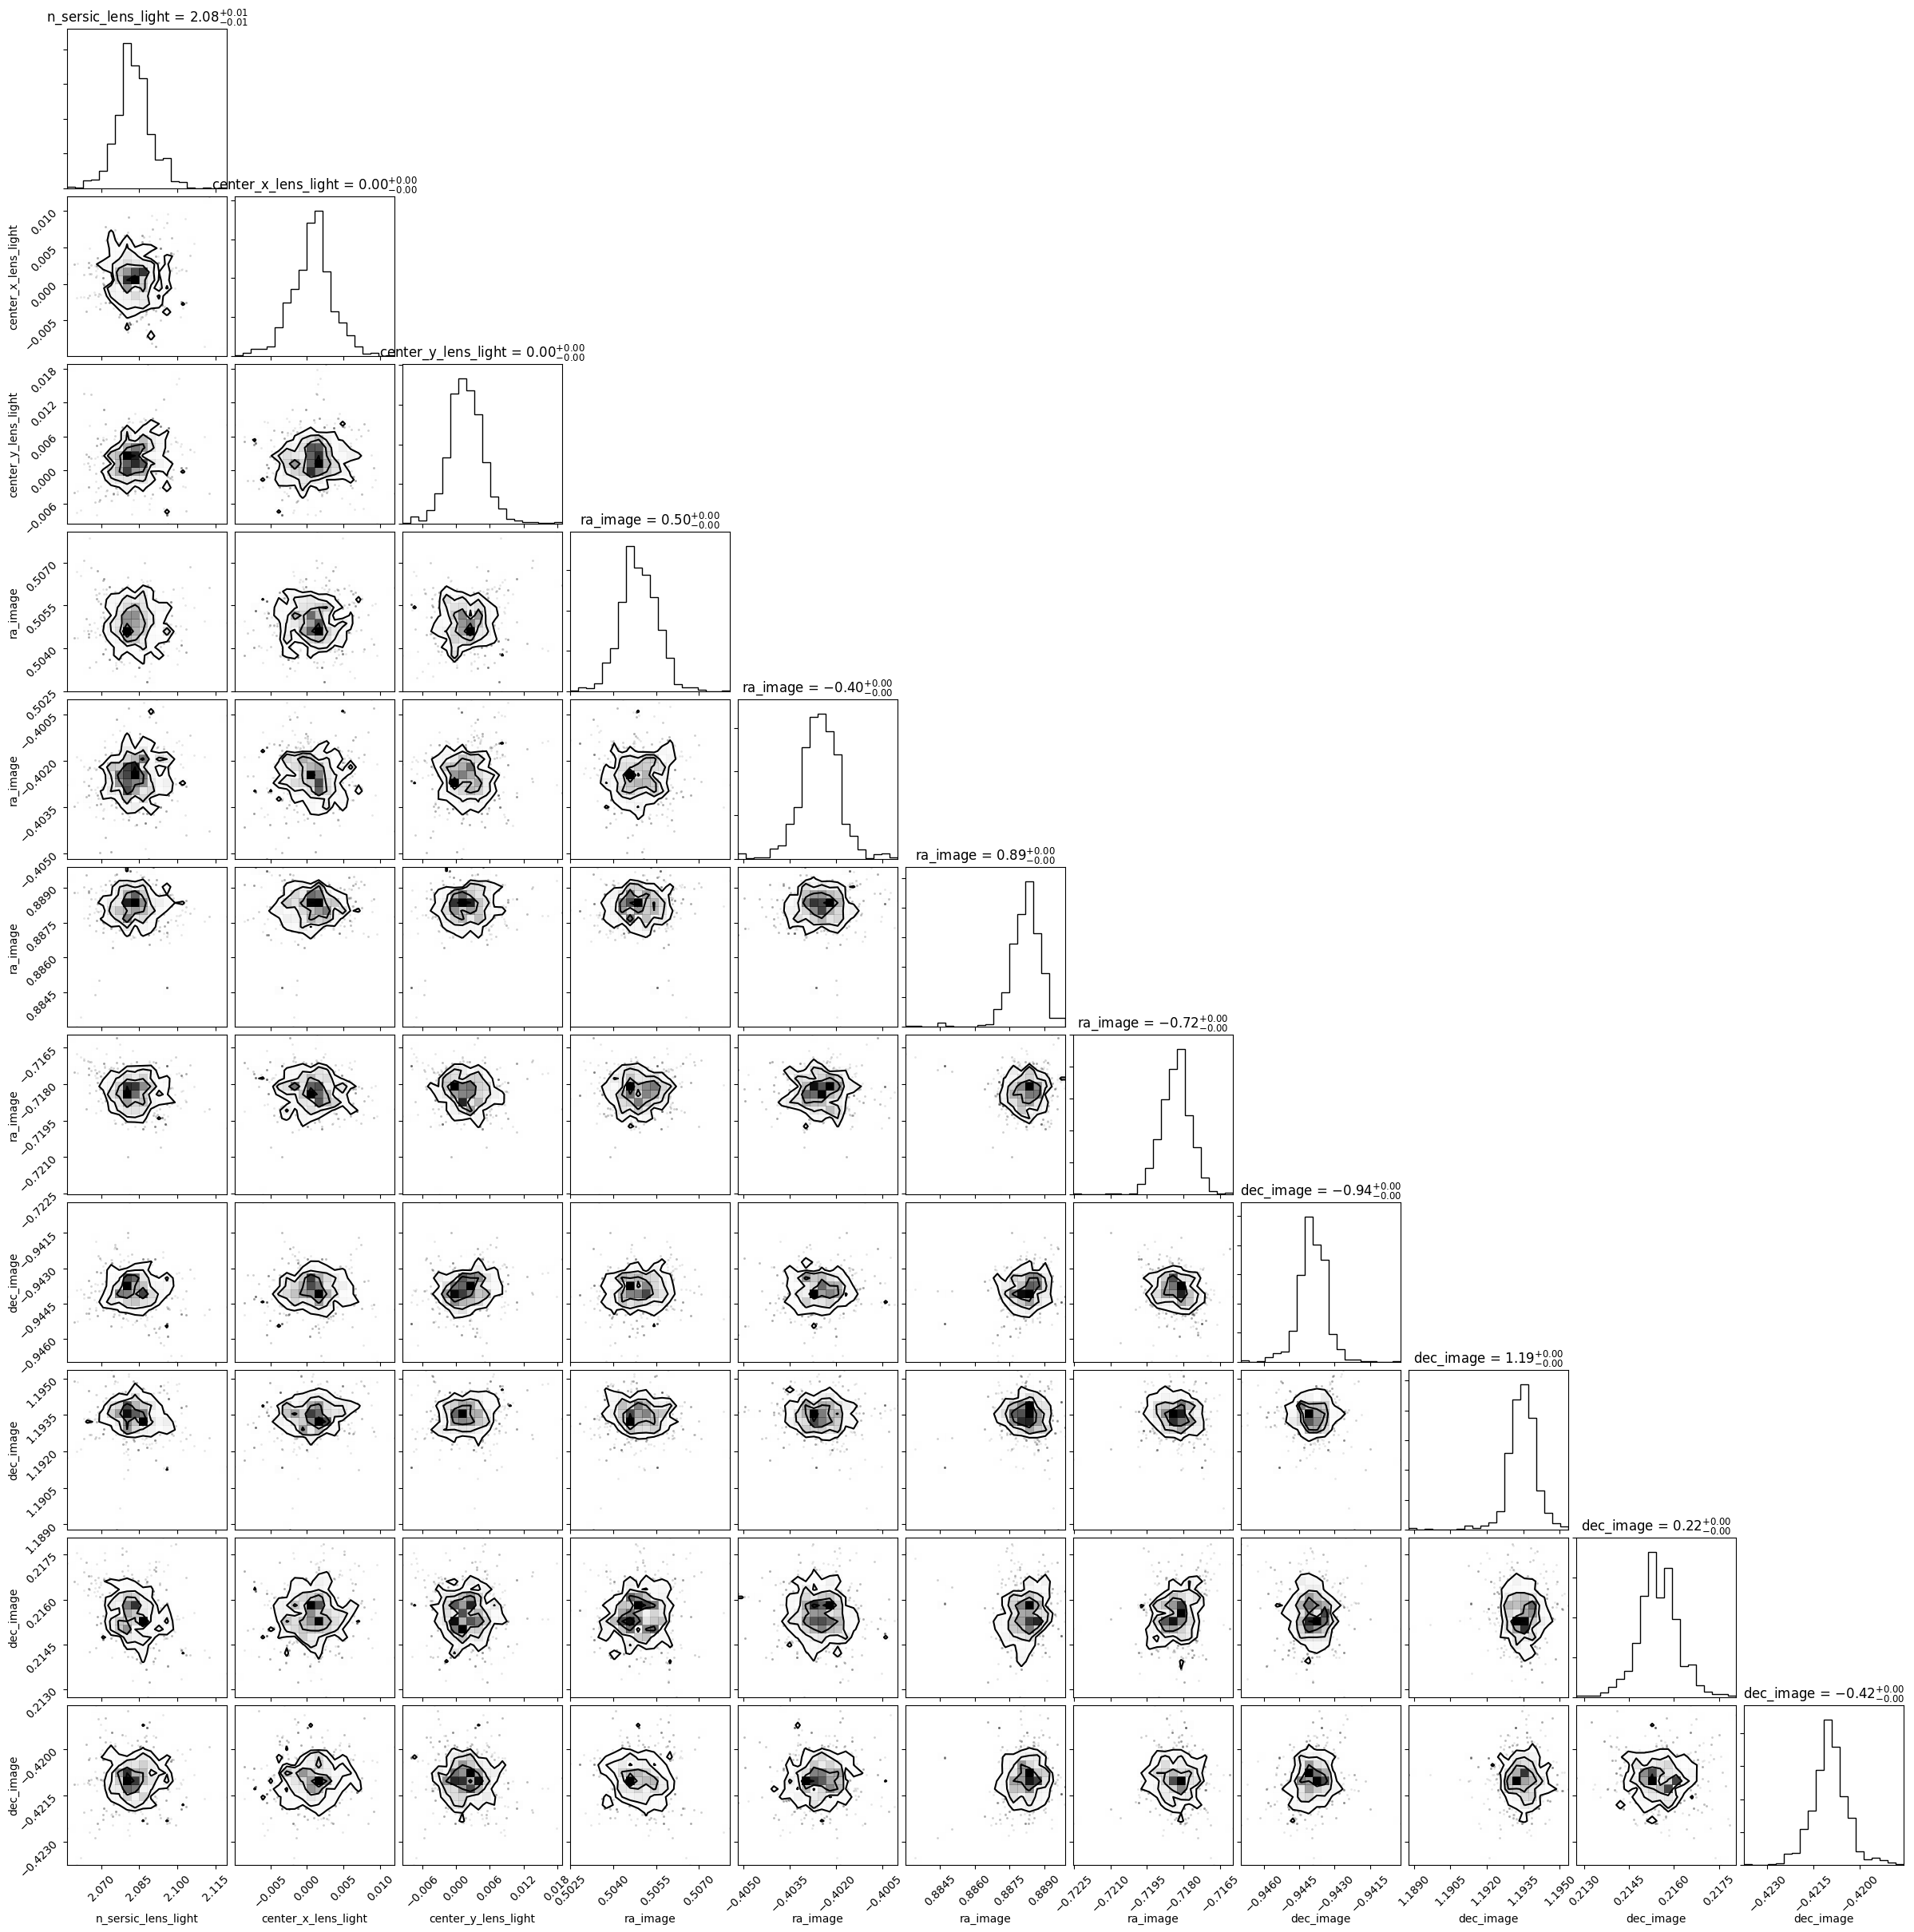

In [6]:
print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
import corner

n, num_param = np.shape(samples_mcmc)
plot = corner.corner(samples_mcmc[:,:8], labels=param_mcmc[:8], show_titles=True)
plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)